# imports

In [14]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D

from astropy import units as u
from astropy.time import Time
import copy
from matplotlib.legend_handler import HandlerTuple
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection

from astropy.io import ascii
from astropy.table import Table, Column, vstack, unique
import numpy as np
import re
import matplotlib.cm as cm
import sys
import os
import json
import requests
import base64
from io import BytesIO

from redback.model_library import all_models_dict
import redback
from redback.simulate_transients import SimulateOpticalTransient

# constants

In [15]:
EVENT_NAME = "S251112cm"
MAX_TIME = 101

# convenience functions and constants for plotting

In [16]:
def ccolor(r,g,b):
    return((r/255.,g/255.,b/255., 1.0))

black=ccolor(0,0,0)
red=ccolor(255,0,0)
blue=ccolor(10,0,255)
green=ccolor(12,83,0)
magenta=ccolor(204,0,204)
goldenrod=ccolor(239,139,8)
orange=ccolor(204,102,0)

# Plotting parameters and functions
pad = 0.25
figsize = 10.0
rc('font',**{'family':'serif','serif':['Times'],'size':6.0*figsize})
rc('text', usetex=True, color=black)

def setup_plot(size=[1.8, 1.5]):

    fig, ax = plt.subplots()
    for i in ax.spines.keys(): ax.spines[i].set_linewidth(0.6*figsize)
    fig.set_size_inches(size[0]*figsize, size[1]*figsize)

    return(fig, ax)

def setup_ticks(ax):

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(direction='in', length=1.5*figsize,
            width=0.5*figsize, which='major', axis='both', colors=black,
            pad=0.3*figsize, top=True, bottom=True, left=True, right=True)
    ax.tick_params(direction='in', length=0.75*figsize,
            width=0.5*figsize, which='minor', axis='both', colors=black,
            pad=0.3*figsize, top=True, bottom=True, left=True, right=True)

def setup_axis_titles(ax, xtitle, ytitle):

        ax.set_xlabel(xtitle, labelpad=pad)
        ax.set_ylabel(ytitle, labelpad=pad)

# BAND_COLOR_MAPPING = {'u': '#8000ff', 
#                       'g': '#386df9', 
#                       'r': '#12c8e6', 
#                       'i': '#5af8c8', 
#                       'z': '#a4f89f', 
#                       'J': '#ecc86f', 
#                       'H': '#ff6d38', 
#                       'K': '#ff0000'}
# BAND_COLOR_MAPPING = {'g':'#02ab2e', 
#                      'r':'#ff0000',
#                       'i':'#ff028d'}
BAND_COLOR_MAPPING = {'g':'#069af3', 
                      'r':'#01ff07',
                      'i':'#fc5a50'}
TRANSIENT_LINESTYLE_MAPPING = {'AT2017gfo':'-',
                               'SN1998bw (Ic-BL)':'--',
                               'SN2017dwh (Ic-BL)':'--',
                               'SN2016gkg (IIb)':':'}

ALPHA = 0.2 # alpha of bands reflecting distance uncertaintyO
                      


# functions for getting event data

In [17]:
def get_treasuremap_data(outfile, event_name):

    if os.path.exists(outfile):
        return(None)

    dirname, basefile = os.path.split(outfile)

    if not os.path.exists(dirname):
        os.makedirs(dirname)

    BASE = "https://treasuremap.space/api/v1"
    TARGET = "pointings"

    if 'TREASURE_MAP_API_TOKEN' not in os.environ.keys():
        raise Exception('Add TREASURE_MAP_API_TOKEN to environment variables')
    else:
        API_TOKEN = os.environ['TREASURE_MAP_API_TOKEN']
    
    json_params = {
        "api_token":API_TOKEN,
        "status":"completed",
        "graceid":"S251112cm"
    }
    
    url = "{}/{}".format(BASE, TARGET)
    
    r = requests.get(url=url, json=json_params)
    
    data = json.loads(r.text)
    
    with open(outfile,'w') as f:
        for dat in data:
            t = Time(dat['time'])
            depth = dat['depth']
            cw = dat['central_wave']
            inst = dat['instrumentid']
    
            band=''
    
            if int(inst)==38:
                inst='DECam'
            elif int(inst)==78:
                inst='MeerLICHT'
            elif int(inst)==79:
                inst='BlackGEM'
            elif int(inst)==11:
                inst='CSS'
    
            if float(cw)==4730.5:
                band = 'g'
            elif float(cw)==7836.21:
                band = 'i'
            elif float(cw)==5800.0:
                band = 'q'
            elif float(cw)==7000.0:
                band = 'V'
    
            if not band:
                raise Exception(f'Unknown cw {cw}, inst {inst}')
    
    
            f.write(f'{t.mjd} {band} {depth} {inst} \n')

def get_event_data(event_name):
    url = f'https://gracedb.ligo.org/api/superevents/{event_name}/files/{event_name}-update.json'

    r = requests.get(url)
    if r.status_code==200:
        data = json.loads(r.text)
        return(data)


def get_event_distance(record):

    # Parse sky map
    if 'skymap' in record['event'].keys():
        event_data = record.get('event')
        skymap_bytes = event_data.get('skymap')
        if isinstance(skymap_bytes, str):
            skymap_bytes = base64.b64decode(skymap_bytes)

    skymap = Table.read(BytesIO(skymap_bytes))
    print(skymap.meta)

    dist_mean = skymap.meta.get('DISTMEAN')
    dist_sigma = skymap.meta.get('DISTSTD')

    return dist_mean, dist_sigma

def is_number(val):
    try:
        float(val)
        return(True)
    except:
        return(False)

# get pointings, event data, distances, distance moduli

In [18]:
pointing_file=f'data/limits/{EVENT_NAME}_pointings.txt'
get_treasuremap_data(pointing_file, EVENT_NAME)
event_data = get_event_data(EVENT_NAME)

# Reference time and distance modulus of event from Update avro packet
ref_date = Time(event_data['event']['time'])
ref_dist, ref_dist_sigma = get_event_distance(event_data)
ref_dm = 5*np.log10(ref_dist)+25.0

# dummy redshift, distances
dummy_redshift = 0.01
from astropy.cosmology import Planck15 as cosmo
dummy_distance = cosmo.luminosity_distance(dummy_redshift).to(u.Mpc).value
dummy_dm = 5 * np.log10(dummy_distance) + 25.0

# uncertainty in magnitude from uncertainty in distance
mag_sigma = 5 * np.log10(ref_dist_sigma) + 25.0 - dummy_dm

OrderedDict([('PIXTYPE', 'HEALPIX'), ('ORDERING', 'NUNIQ'), ('COORDSYS', 'C'), ('MOCORDER', 9), ('INDXSCHM', 'EXPLICIT'), ('OBJECT', 'S251112cm'), ('INSTRUME', 'H1,L1,V1'), ('DATE-OBS', '2025-11-12T15:18:45.361498'), ('MJD-OBS', 60991.63802501734), ('DATE', '2025-11-13T01:01:37.772774'), ('CREATOR', 'ligo-skymap-from-samples'), ('ORIGIN', 'LIGO/Virgo/KAGRA'), ('RUNTIME', 8.322836274281144), ('DISTMEAN', 93.2131421111329), ('DISTSTD', 27.473722661311815), ('VCSVERS', 'ligo.skymap 2.4.1'), ('HISTORY', ['', 'Generated by running the following script:', 'ligo-skymap-from-samples worker -l info -n gwcelery-multiprocessing-', 'worker@%h -f .local/state/log/%n.log -Q multiprocessing -c 1 --prefetch-', 'multiplier 1'])])


# plot!

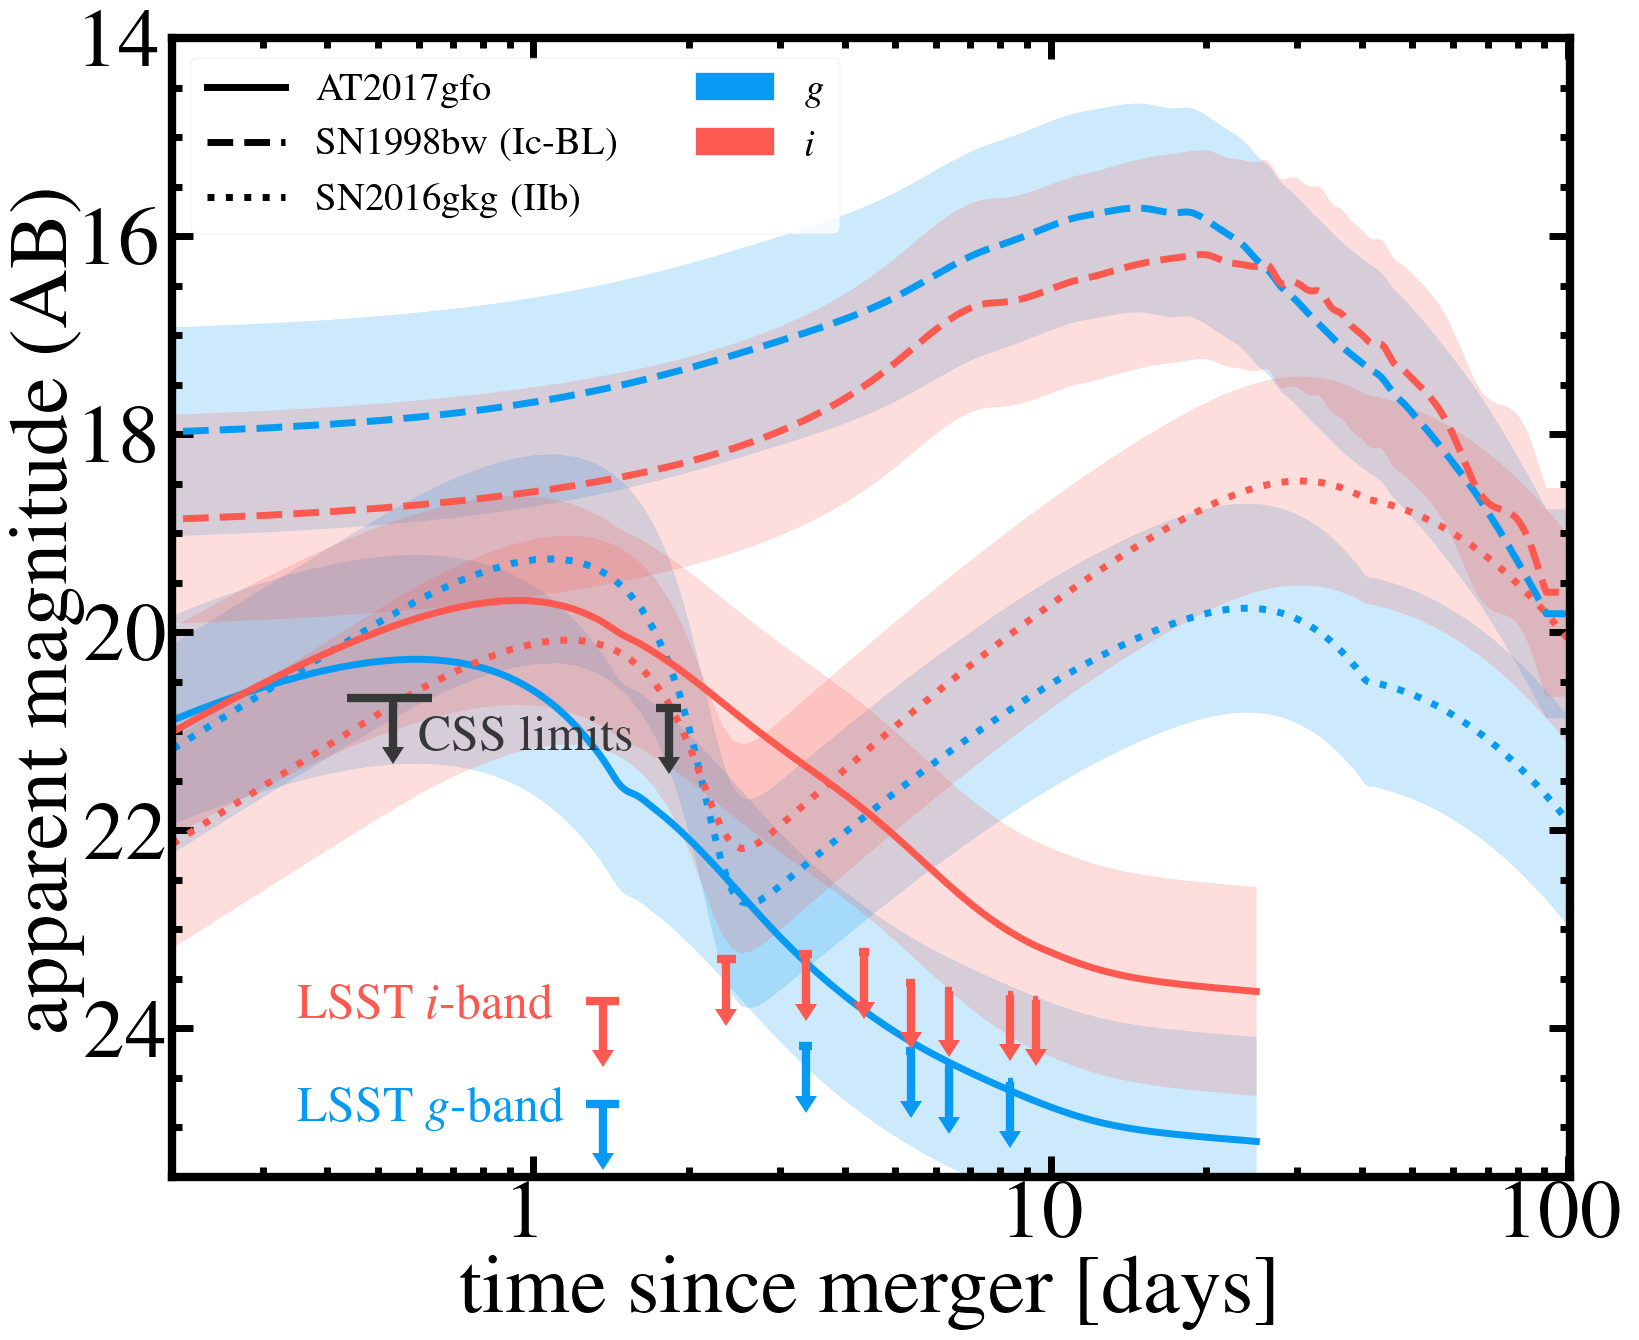

In [19]:
# set some plotting parameters
rc('font',**{'family':'serif','serif':['Times'],'size':6.0*figsize})
rc('text', usetex=True, color=black)

# set up the figure
fig, ax = setup_plot(size=[1.8, 1.5])

setup_ticks(ax)
setup_axis_titles(ax,'time since merger [days]','apparent magnitude (AB)')

ax.set_ylim([25.5, 14.0])
ax.set_xlim([0.2, MAX_TIME])
ax.set_xscale('log')



# Add in CSS limits
table_css = Table.read(pointing_file, format='ascii')
mask = table_css['col4']=='CSS'
table_css = table_css[mask]
table_css['col1']=table_css['col1']-ref_date.mjd

for i in np.arange(int(MAX_TIME)):
    mask = (table_css['col1']>i) & (table_css['col1']<i+1)

    time = np.mean(table_css['col1'][mask])
    depth = np.mean(table_css['col3'][mask])

    ax.errorbar(time, depth, yerr=0.5, lolims=True, marker='_', color='#363737', markersize=64, linewidth=6, capsize=8, label=None,
               zorder=3)
    ax.hlines(depth, time-0.1, time+0.1, color='#363737', linewidth=6, zorder=3)


# Add in Rubin limits
table_rubin = Table.read('data/limits/rubin_limits.txt', format='ascii')

for row in table_rubin:
    date = Time(row['date']).mjd-ref_date.mjd

    gdepth = row['glim']
    idepth = row['ilim']

    if is_number(gdepth):
        gdepth=float(gdepth)
        
        ax.errorbar(date, gdepth, yerr=0.5, lolims=True, marker='_', color=BAND_COLOR_MAPPING['g'], 
                    markersize=64, linewidth=6, capsize=8, label=None, zorder=3)
        ax.hlines(gdepth, date-0.1, date+0.1, color=BAND_COLOR_MAPPING['g'], linewidth=6, zorder=3)
        
    if is_number(idepth):
        idepth=float(idepth)

        ax.errorbar(date, idepth, yerr=0.5, lolims=True, marker='_', color=BAND_COLOR_MAPPING['i'], 
                    markersize=64, linewidth=6, capsize=8, label=None, zorder=3)
        ax.hlines(idepth, date-0.1, date+0.1, color=BAND_COLOR_MAPPING['i'], linewidth=6, zorder=3)



# Add in models from redback
time_array = np.linspace(0, MAX_TIME, 1000)
time_array_kn = np.linspace(0, 25, 1000) # use different time array because the KN model isn't really accurate beyond 25-30 days

# Generate models
for filt in ['g','i']:

    # AT2017gfo-LIKE KILONOVA 
    # See: https://iopscience.iop.org/article/10.3847/2041-8213/aa9c84/pdf
    model_params = {
    'output_format': 'magnitude',
    'redshift': dummy_redshift,
    'mej_1': 0.020,
    'vej_1': 0.256,
    'kappa_1': 0.5,
    'temperature_floor_1': 3983,
    'mej_2': 0.047,
    'vej_2': 0.152,
    'kappa_2': 3.0,
    'temperature_floor_2': 1308,
    'mej_3': 0.011,
    'vej_3': 0.137,
    'kappa_3': 10.0,
    'temperature_floor_3': 3745,
    }

    mags = all_models_dict['three_component_kilonova_model'](time_array_kn, **model_params, bands=['lsst'+filt])
    mags = mags-dummy_dm
    mags_plus = mags + mag_sigma
    mags_minus = mags - mag_sigma

    ax.plot(time_array_kn, mags + ref_dm, 
            zorder=2,
            color=BAND_COLOR_MAPPING[filt],  
            linewidth=5, linestyle=TRANSIENT_LINESTYLE_MAPPING['AT2017gfo'])
    ax.fill_between(time_array_kn, mags_plus + ref_dm, mags_minus + ref_dm, 
                    zorder=1,
                    color=BAND_COLOR_MAPPING[filt], alpha=ALPHA)

    # # MAGNETAR AND NICKEL-POWERED SN Ic-BL SN2017dwh
    # # See: https://iopscience.iop.org/article/10.3847/1538-4357/aafa13/pdf
    # model_params = {
    # 'output_format': 'magnitude',
    # 'redshift': dummy_redshift,
    # 'f_nickel': np.float64(0.57),
    #  'p0': np.float64(6.41),
    #  'bp': np.float64(10**(0.22)),
    #  'mass_ns': 1.82,
    #  'theta_pb': 1.5357176532330916,
    #  'mej': np.float64(10**(0.22)),
    #  'vej': np.float64(12100),
    #  'kappa': 0.17,
    #  'kappa_gamma': np.float64(10**(-1.19)),
    #  'temperature_floor': np.float64(4550)
    # }

    # mags = all_models_dict['magnetar_nickel'](time_array, **model_params, bands=['lsst'+filt])
    # mags = mags-dummy_dm
    # mags_plus = mags + mag_sigma
    # mags_minus = mags - mag_sigma

    # ax.plot(time_array, mags + ref_dm, 
    #         zorder=2,
    #         color=BAND_COLOR_MAPPING[filt], 
    #         linewidth=5, linestyle=TRANSIENT_LINESTYLE_MAPPING['SN2017dwh (Ic-BL)'])
    # ax.fill_between(time_array, mags_plus + ref_dm, mags_minus + ref_dm, 
    #                 zorder=1,
    #                 color=BAND_COLOR_MAPPING[filt], alpha=ALPHA)

    # SN Ic-BL SN1998bw
    model_params = {
    'output_format': 'magnitude',
    'redshift': dummy_redshift,
    'amplitude':1.0
    }

    mags = all_models_dict['sn1998bw_template'](time_array, **model_params, bands=['lsst'+filt])
    mags = mags-dummy_dm
    mags_plus = mags + mag_sigma
    mags_minus = mags - mag_sigma

    ax.plot(time_array, mags + ref_dm, 
            zorder=2,
            color=BAND_COLOR_MAPPING[filt], 
            linewidth=5, linestyle=TRANSIENT_LINESTYLE_MAPPING['SN1998bw (Ic-BL)'])
    ax.fill_between(time_array, mags_plus + ref_dm, mags_minus + ref_dm, 
                    zorder=1,
                    color=BAND_COLOR_MAPPING[filt], alpha=ALPHA)
    
    # SN IIb SN2016gkg
    # See: https://arxiv.org/pdf/1611.06451
    model_params = {
        'output_format': 'magnitude',
        'redshift': dummy_redshift,
        'log10_mass': np.log10(3.0e-2),
        'log10_radius': np.log10(3.0e12),
        'log10_energy': np.log10(1.0e51),
        'nn': 10.0,
        'delta': 1.0,
        'f_nickel': np.float64(0.1),
        'mej': np.float64(2.0),
        'vej': np.float64(8100),
        'kappa': 1.0,
        'kappa_gamma': np.float64(0.01),
        'temperature_floor': np.float64(3550)}

    mags = all_models_dict['shock_cooling_and_arnett'](time_array, **model_params, bands=['lsst'+filt])
    mags = mags-dummy_dm
    mags_plus = mags + mag_sigma
    mags_minus = mags - mag_sigma

    ax.plot(time_array, mags + ref_dm,
            zorder=2,
            color=BAND_COLOR_MAPPING[filt], 
            # label='SN IIb, '+rf'${filt}$'
            linewidth=5, linestyle=TRANSIENT_LINESTYLE_MAPPING['SN2016gkg (IIb)'])
    ax.fill_between(time_array, mags_plus + ref_dm, mags_minus + ref_dm, 
                    zorder=1,
                    color=BAND_COLOR_MAPPING[filt], alpha=ALPHA)

# dummy curves / fill between, for legend
for transient in ['AT2017gfo', 'SN1998bw (Ic-BL)', 'SN2016gkg (IIb)']:
    ax.plot([-10], [-10], # plotted at x, y which are not visible
            linewidth=5, color='k', linestyle=TRANSIENT_LINESTYLE_MAPPING[transient],
            label=transient)
for filt in ['g', 'i']:
    ax.fill_between([-10], [-10], # plotted at x, y which are not visible
                    color=BAND_COLOR_MAPPING[filt],
                    label=r"$"+filt+r"$")


# annotate CSS and Rubin limits
ax.text(0.6, 21.2, 'CSS limits', color='#363737', fontsize=36)
ax.text(0.35, 23.9, 'LSST $i$-band', color=BAND_COLOR_MAPPING['i'], fontsize=36)
ax.text(0.35, 24.95, 'LSST $g$-band', color=BAND_COLOR_MAPPING['g'], fontsize=36)

# x-axis
ax.set_xticks([1,10,100])
ax.set_xticklabels(['1','10','100'])

# legend
plt.legend(fontsize=28, loc="upper left", ncol=2)

# finally, save figure
plt.tight_layout()
plt.savefig("S251112cm_EM_model_comparisons.png", bbox_inches="tight")
plt.savefig("S251112cm_EM_model_comparisons.pdf", bbox_inches="tight")